In [194]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [261]:
dcs = pd.read_csv('credits.csv', delimiter = ';')
dcs = dcs.iloc[:,[0,1,2,3,4,5,6,8,9,7]]
dcs = dcs[dcs['sum_of_active_credits']<20000000]
dcs.loc [dcs['amount_npl30+_5years'] > 60, 'amount_npl30+_5years'] = 60       
dcs.describe().round(3)

# по чистке: убрал экстремально высокие значения я кредитной нагрузки (> 20 млн руб)
# максималньное количество просрочек за период - условно приравнял к продолжительности периода (60 месяцев)

,age,sex,fam,child,edu,seniority,income,amount_of_payd_credits,sum_of_active_credits,amount_npl30+_5years
count,7079.000,7071.000,7079.000,7078.000,7077.000,7079.000,7079.000,7079.000,7.079000e+03,7079.000
mean,39.778,0.611,1.157,0.875,0.420,1.718,55438.381,4.310,4.334457e+05,2.473
std,10.350,0.488,0.958,0.913,0.536,1.200,70593.550,8.567,1.087674e+06,6.495
min,25.000,0.000,0.000,0.000,0.000,0.000,1111.000,0.000,0.000000e+00,0.000
25%,35.000,0.000,1.000,0.000,0.000,1.000,30000.000,1.000,0.000000e+00,0.000
50%,35.000,1.000,1.000,1.000,0.000,2.000,42200.000,3.000,3.575700e+04,0.000
75%,45.000,1.000,1.000,2.000,1.000,3.000,60000.000,6.000,4.000000e+05,2.000
max,55.000,1.000,3.000,4.000,2.000,3.000,2189178.000,321.000,1.910000e+07,60.000


In [262]:
#  Столбцы для альтернативных гипотез

## Показатель  кредитной нагрузки (Долг по действующим кредитам к среднемесячному доходу)
dcs['cred_to_income'] = dcs['sum_of_active_credits'] / dcs['income'] 


## Семейных заёмщиков выделяем в Пол № 3 
# (пояснение - по условиям кредитования если Заёмщик в браке, то Супруга выступает (со)Заёмщиком № 2 по договору
# по обязательствам отвечают оба супруга и пол (уже) не влияет на кредитоспособность / дает искажение / может быть) 
dcs.loc [dcs.fam == 1, 'sex_fam'] = -1 
dcs.loc [dcs.fam != 1, 'sex_fam'] = dcs.sex

In [263]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

clean_dataset(dcs).describe().round(2)

,age,sex,fam,child,edu,seniority,income,amount_of_payd_credits,sum_of_active_credits,amount_npl30+_5years,cred_to_income,sex_fam
count,7068.00,7068.00,7068.00,7068.00,7068.00,7068.00,7068.00,7068.00,7068.00,7068.00,7068.00,7068.00
mean,39.78,0.61,1.16,0.87,0.42,1.72,55425.41,4.31,433506.30,2.48,7.63,-0.39
std,10.35,0.49,0.96,0.91,0.54,1.20,70636.02,8.57,1087878.44,6.50,24.71,0.79
min,25.00,0.00,0.00,0.00,0.00,0.00,1111.00,0.00,0.00,0.00,0.00,-1.00
25%,35.00,0.00,1.00,0.00,0.00,1.00,30000.00,1.00,0.00,0.00,0.00,-1.00
50%,35.00,1.00,1.00,1.00,0.00,2.00,42190.00,3.00,35878.50,0.00,0.91,-1.00
75%,45.00,1.00,1.00,2.00,1.00,3.00,59974.50,6.00,400000.00,2.00,8.70,0.00
max,55.00,1.00,3.00,4.00,2.00,3.00,2189178.00,321.00,19100000.00,60.00,895.27,1.00


(12.0, 0.0)

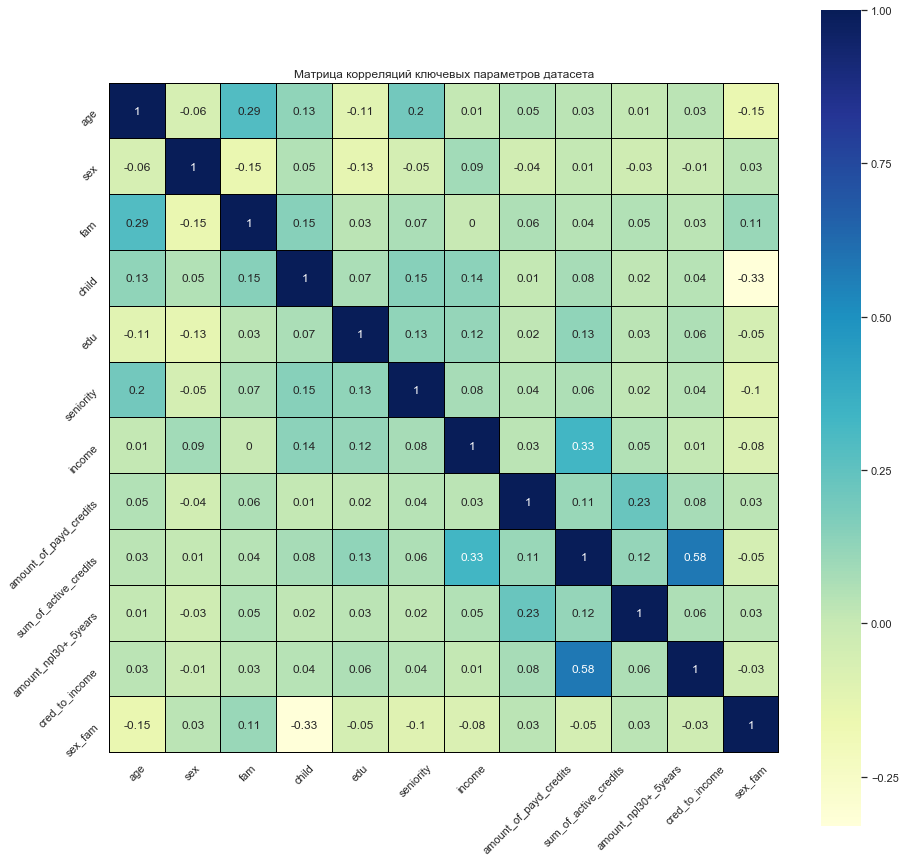

In [264]:
dcs_corr = dcs.corr().round(2)
sns.set(rc={'figure.figsize':(15,15)})
ax = sns.heatmap(dcs_corr,  
                annot = True, 
                fmt='.3g', 
                cmap= 'YlGnBu', 
                linewidths=0.1, 
                linecolor='black', 
                square=True)

plt.title('Матрица корреляций ключевых параметров датасета')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

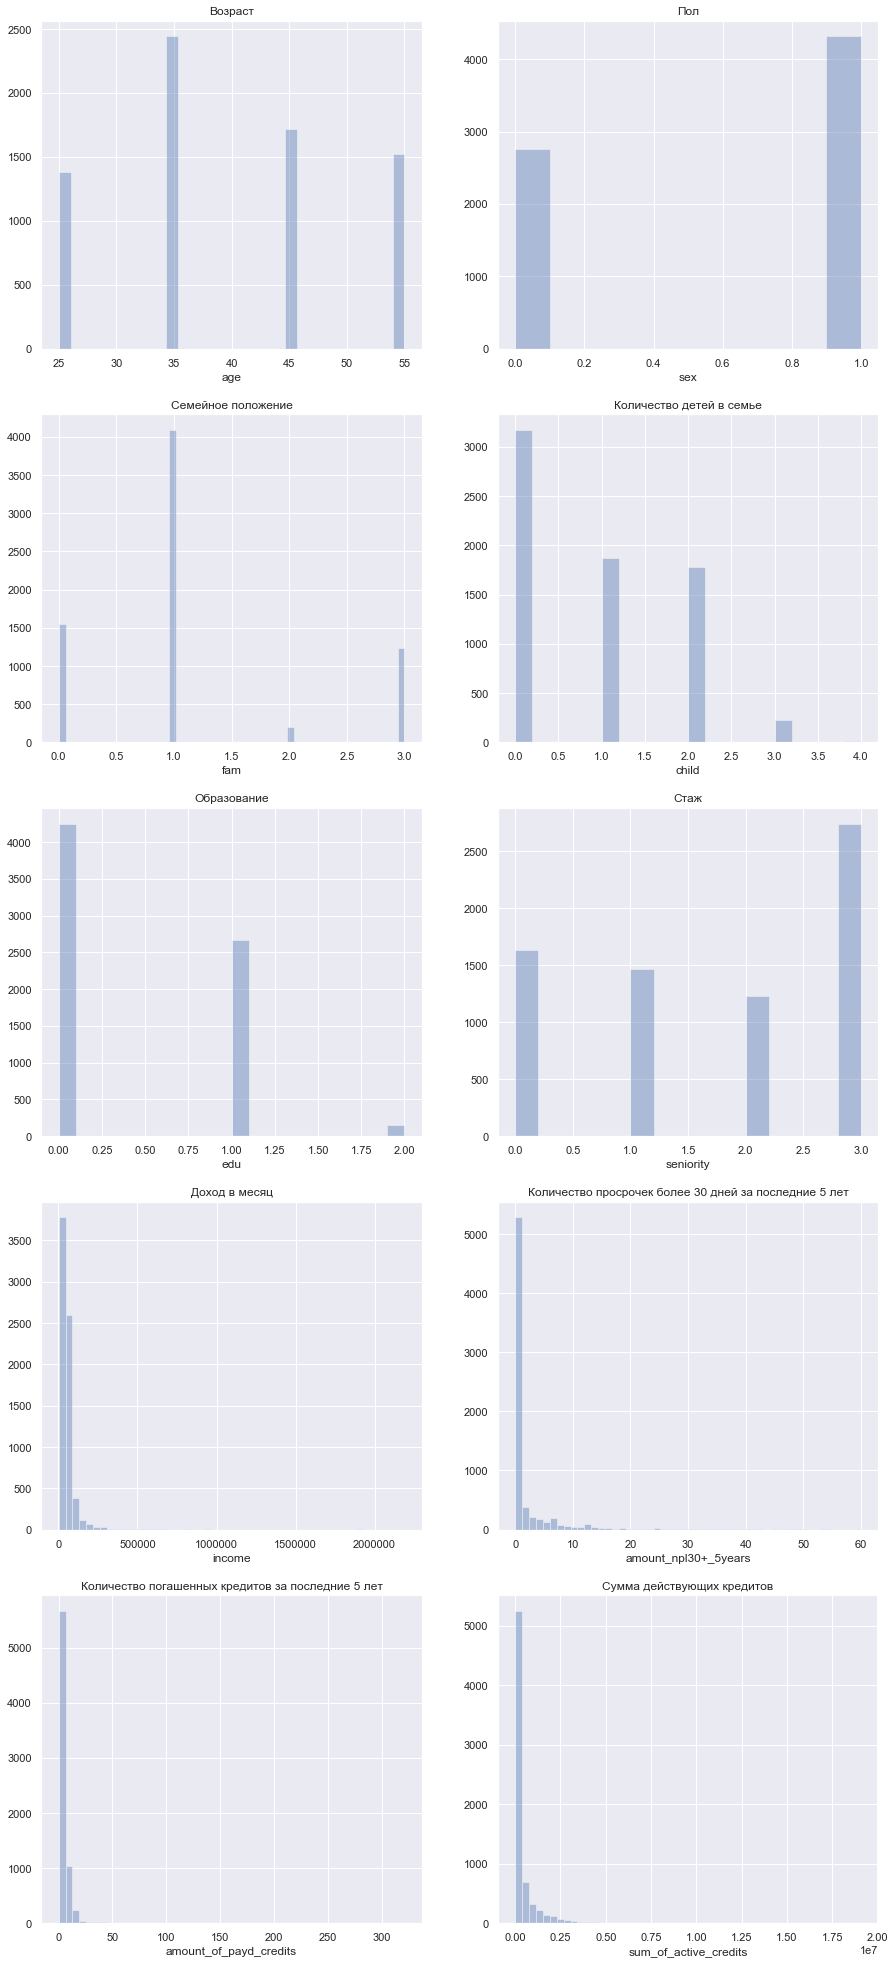

In [265]:
fig, ((ax_0, ax_1), 
      (ax_2, ax_3), 
      (ax_4, ax_5),
      (ax_6, ax_7),
      (ax_8, ax_9)
     )  = plt.subplots(nrows = 5, ncols = 2, figsize = (15, 35))


ax_0.set_title('Возраст')
sns.distplot(dcs['age'],  kde = False, ax = ax_0)

ax_1.set_title('Пол')
sns.distplot(dcs['sex'], kde = False, ax = ax_1)

ax_2.set_title('Семейное положение')
sns.distplot(dcs['fam'], kde = False, ax = ax_2)

ax_3.set_title('Количество детей в семье')
sns.distplot(dcs['child'], kde = False, ax = ax_3)

ax_4.set_title('Образование')
sns.distplot(dcs['edu'], kde = False, ax = ax_4)

ax_5.set_title('Стаж')
sns.distplot(dcs['seniority'], kde = False, ax = ax_5)

ax_6.set_title('Доход в месяц')
sns.distplot(dcs['income'], kde = False, ax = ax_6)

ax_7.set_title('Количество просрочек более 30 дней за последние 5 лет')
sns.distplot(dcs['amount_npl30+_5years'], kde = False, ax = ax_7)

ax_8.set_title('Количество погашенных кредитов за последние 5 лет')
sns.distplot(dcs['amount_of_payd_credits'], kde = False, ax = ax_8)

ax_9.set_title('Сумма действующих кредитов')
sns.distplot(dcs['sum_of_active_credits'], kde = False, ax = ax_9)

plt.show()

апредельный уровень корелляции между уровнем кредитной нагрузки и количеством 

In [266]:
def err_regress (feature_col):
    X = dcs.iloc[:,feature_col]
    y = dcs.iloc[:,[9]]
    reg = LinearRegression().fit(X, y)
    print('Weights: {}'.format(reg.coef_))
    print('Bias: {}'.format(reg.intercept_))
    pred_values = reg.predict(X)
    print('Error: {}'.format(mean_absolute_error(pred_values, y)))  
    return mean_absolute_error(pred_values, y)

In [267]:
def feature_report (feature_col):
    output_y = dcs.iloc[:,[9]]
    input_x  = dcs.iloc[:,feature_col]
    le=LabelEncoder()
    targets=(output_y==1)
    Y= le.fit_transform(targets)
    x_train, x_test, y_train, y_test = train_test_split(input_x, 
                                                        Y, 
                                                        test_size = 0.2, 
                                                        random_state = 100)
    model=RandomForestClassifier(n_estimators=100)
    model.fit(x_train,y_train)
    model_pred = model.predict(x_test)
    print(classification_report(y_test, model_pred))
    print('точность предсказания модели составила: ', 
          (100*model.score(x_test, y_test)).round(3),
           'процентов')
    # формируем рэнкинг параметров по уровню значимости влияния на платежный статус
    headers = list(input_x.columns.values)
    feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)
    f, ax = plt.subplots(figsize=(6, 6))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Уровень значимости параметров')
    plt.ylabel('Параметры, влияющие на платежный статус')
    plt.title('Рэнкинг значимости параметров, влияющих на платежный статус')
    plt.show()

Weights: [[-1.34288777e-02 -2.63597428e-01  2.54458267e-01  5.50872329e-02
   1.27129172e-01  3.22250179e-02  1.46756213e-06  1.66395223e-01
   5.11216543e-07]]
Bias: [1.69961404]
Error: 3.2118078667472423


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       0.88      0.99      0.94      1244
           1       0.53      0.05      0.10       170

    accuracy                           0.88      1414
   macro avg       0.71      0.52      0.52      1414
weighted avg       0.84      0.88      0.84      1414

точность предсказания модели составила:  88.048 процентов


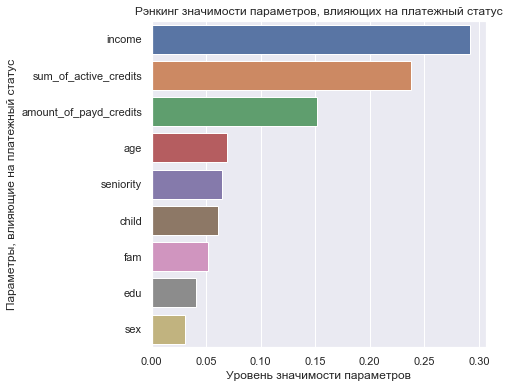

In [278]:
#  Сценарий 1 Базовый - модель со всеми признаками исходного датасета (как есть)
err_regress(   [0,1,2,3,4,5,6,7,8])
feature_report([0,1,2,3,4,5,6,7,8])

Достойный в целом результат модели, но выделяются 2 группы факторов: доход и факторы кредитной истории;  социальные факторы классика. Посмотрим как эти факторов работают раздельно:

Weights: [[1.47449275e-06 1.68118965e-01 5.27012255e-07]]
Bias: [1.4410519]
Error: 3.2216750636015483


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       0.89      0.97      0.92      1244
           1       0.26      0.09      0.13       170

    accuracy                           0.86      1414
   macro avg       0.57      0.53      0.53      1414
weighted avg       0.81      0.86      0.83      1414

точность предсказания модели составила:  85.997 процентов


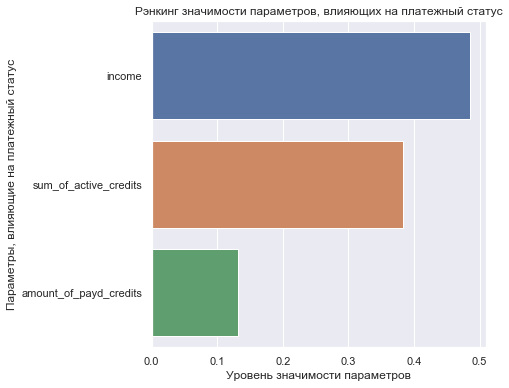

In [279]:
#  Сценарий 2 - только доходы, кредитный опыт и нагрузка
feature_columns = [6, 7, 8]
err_regress(feature_columns)
feature_report(feature_columns)

Много ушло факторов, но потери в информативности модели незначительны.  В этой группе факторы много более связаны между собой чем следующая / социальная группа факторов

Weights: [[-0.00493757 -0.30008673  0.33280114  0.11025317  0.34565568]]
Bias: [2.22903348]
Error: 3.4825121529417067


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1244
           1       0.08      0.01      0.01       170

    accuracy                           0.87      1414
   macro avg       0.48      0.50      0.47      1414
weighted avg       0.78      0.87      0.82      1414

точность предсказания модели составила:  87.199 процентов


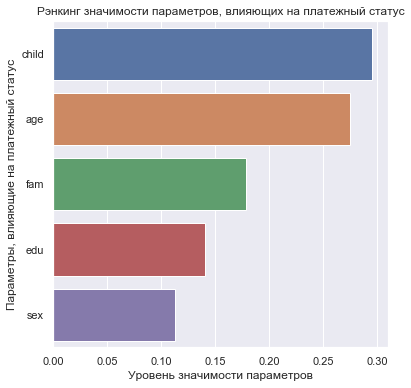

In [282]:
#  Сценарий 3 - только базовые социальные признаки

err_regress([0,1,2,3,4])
feature_report([0,1,2,3,4])

Небольшие потери за счет снижения  количества факторов.  Без дополнительных сведений о кредитной нагрузке фактор наличия / количества детей сильно прибавляет в весе ;)  -  в целом - топчемся на месте

Weights: [[ 0.00299417 -0.429127  ]]
Bias: [2.61874659]
Error: 3.4939297128158153


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1244
           1       0.00      0.00      0.00       170

    accuracy                           0.88      1414
   macro avg       0.44      0.50      0.47      1414
weighted avg       0.77      0.88      0.82      1414

точность предсказания модели составила:  87.977 процентов


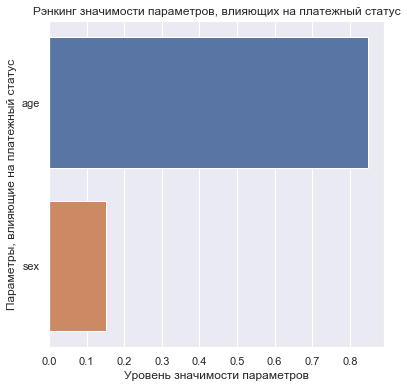

In [283]:
#  Сценарий 4 -  Радикальный / оставим только возраст и пол
feature_columns = [0,1]
err_regress([0,1])
feature_report([0,1])

То есть частоту выхода на просрочку можно с той же точностью   предсказывать только по 2 факторам, которые лежат на поверхности, и не заморачиваться .... если верить датасету

Weights: [[-3.52477679e-03  1.52201140e-01  1.98419825e-01  3.98903413e-02
   1.26453813e-06  1.67113406e-01  5.18023925e-07  2.84112142e-01]]
Bias: [1.42609914]
Error: 3.214422065432469


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       0.88      0.99      0.94      1244
           1       0.47      0.05      0.09       170

    accuracy                           0.88      1414
   macro avg       0.68      0.52      0.51      1414
weighted avg       0.83      0.88      0.83      1414

точность предсказания модели составила:  87.907 процентов


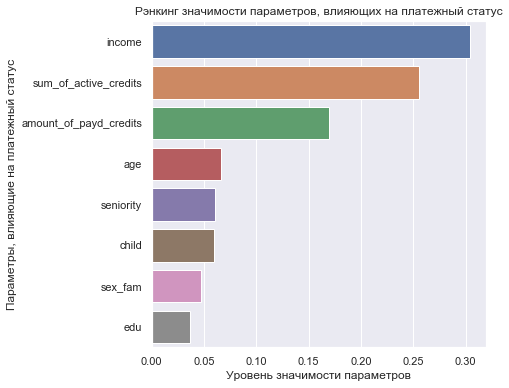

In [284]:
#  Cценарий 5-Альтернативный -  Объединяем признаки пол и семейное положение
# предполагаем, что в случаях когда стороной кредитного договора выступают одновременно 2 супруга - 
# влияние на просрочку пола лица, обратившегося за кредитом, сглаживается

err_regress(   [0,3,4,5,6,7,8,11])
feature_report([0,3,4,5,6,7,8,11])


На представленных данных гипотеза не подтверждена

Weights: [[-0.01266373 -0.19877377  0.26341807  0.09492657  0.24924494  0.04563771
   0.17102441  0.01115121]]
Bias: [1.70800358]
Error: 3.2425533393734547


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1244
           1       0.29      0.09      0.14       170

    accuracy                           0.86      1414
   macro avg       0.59      0.53      0.53      1414
weighted avg       0.82      0.86      0.83      1414

точность предсказания модели составила:  86.492 процентов


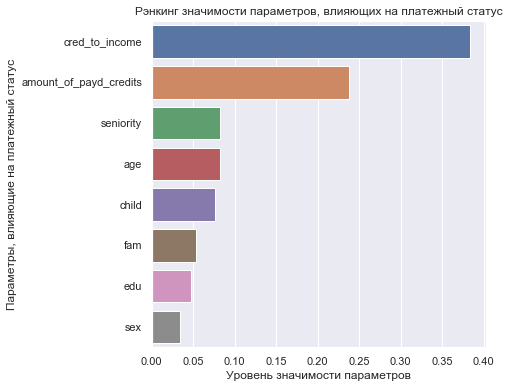

In [270]:
#  Cценарий 6 -Альтернативный -  Объединяем признаки дохода и суммы кредитов 
#  рассматриваем гипотезу, что относительный показатель уровня кредитной нагрузки более информативен,
# чем абсолютные суммы уровня дохода и сумммц используемых кредитов

err_regress(   [0,1,2,3,4,5,7,10])
feature_report([0,1,2,3,4,5,7,10])

и опять гипотеза не подтверждена ... 



Попробуем посчитать модель линейной регрессии из каких 4 параметров дает наименьшую ошибку

In [274]:
def err_regress_short (feature_col):
    X = dcs.iloc[:,feature_col]
    y = dcs.iloc[:,[9]]
    reg = LinearRegression().fit(X, y)
    pred_values = reg.predict(X)
    return mean_absolute_error(pred_values, y)

data = [{'Признаки': '', 'mean_absolute_error': 0}] 
df = pd.DataFrame(data)
i = 0

for i1 in range(8):
    for i2 in range(8):
        for i3 in range(8):
            for i4 in range(8):
                if (i1 != i2 & i1 != i3 & i1 != i4 & i2 != i3 & i2 != i4 & i3 != i4):
                    f_columns = [dcs.columns[i1], dcs.columns[i2], dcs.columns[i3], dcs.columns[i4]]
                    df.loc[i] = [f_columns, err_regress_short ([i1, i2, i3, i4])]
                    i = i +1
                             
                
                
print('Признаки', df.sort_values('mean_absolute_error', ascending=True).iloc[0,0])           
print('mean_absolute_error = ', df.sort_values('mean_absolute_error', ascending=True).iloc[0,1])  

Признаки ['amount_of_payd_credits', 'fam', 'income', 'sex']
mean_absolute_error =  3.247053152611591


Точость модели Случайных лесов будет наибольшей если мы подберем следующие  4 параметра

In [ ]:
def rand_forest_short (feature_col):
    output_y = dcs.iloc[:,[9]]
    input_x  = dcs.iloc[:,feature_col]
    le=LabelEncoder()
    targets=(output_y==1)
    Y= le.fit_transform(targets)
    x_train, x_test, y_train, y_test = train_test_split(input_x, 
                                                        Y, 
                                                        test_size = 0.2, 
                                                        random_state = 100)
    model=RandomForestClassifier(n_estimators=100)
    model.fit(x_train,y_train)
    model_pred = model.predict(x_test)
    return (100*model.score(x_test, y_test)).round(3)

d = [{'Признаки': '', 'Точность_модели_RF': 0}] 
df1 = pd.DataFrame(d)
i = 0

for i1 in range(8):
    for i2 in range(8):
        for i3 in range(8):
            for i4 in range(8):
                if  i1!=i2  and i1!=i3 and i1!=i4 and i2!=i3 and i2!=i4 and i3!=i4:
                    f_columns = [dcs.columns[i1], dcs.columns[i2], dcs.columns[i3], dcs.columns[i4]]
                    df1.loc[i] = [f_columns, rand_forest_short ([i1, i2, i3, i4])]
                    i = i +1
                             
                
                
print('Признаки', df1.sort_values('Точность_модели_RF', ascending=False).iloc[0,0])           
print('Точность предсказания модели в % = ', df1.sort_values('Точность_модели_RF', ascending=False).iloc[0,1])  

Признаки ['seniority', 'fam', 'sex', 'age']

Точность предсказания модели в % =  87.977









Общие выводы:

"Не следует преумножать сущности сверх необходимости"


выборка нерепрезентативна, имхо